# Hotdog Classifier

Opsætning af FastAI

In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 8.1MB/s 
     |████████████████████████████████| 194kB 10.5MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 1.2MB 14.3MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
Mounted at /content/gdrive


In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [4]:
# Azure API Key
key = os.environ.get('AZURE_SEARCH_KEY', '88f816fb74d147e08b211baf0cceebbb')

In [5]:
bear_types = 'hotdog', 'random'
path = Path('hotdogs')

In [6]:
# Looper over de specificerede typer og søger på dem hver især
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [7]:
# Tjekker om der er billeder som er failed 
fns = get_image_files(path)
failed = verify_images(fns)
failed

(#2) [Path('hotdogs/hotdog/00000010.jpg'),Path('hotdogs/hotdog/00000034.jpg')]

In [8]:
# Fjerner billeder som er failed
failed.map(Path.unlink);

In [9]:
# Laver DataLoaders for datasettet vi lige har downloaded udfra følgende:
# What kinds of data we are working with
# How to get the list of items
# How to label these items
# How to create the validation set

bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [10]:
# Fortæller FastAI hvor kilden af dataen kan findes
dls = bears.dataloaders(path)

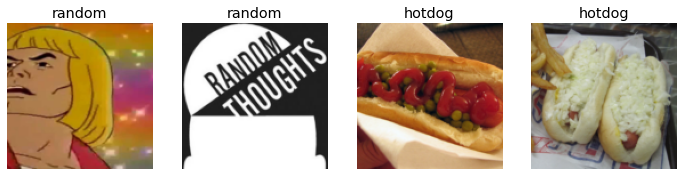

In [11]:
dls.valid.show_batch(max_n=4, nrows=1)

In [12]:
# Træning af modellen
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [13]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.237174,1.151421,0.339286,00:38


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.266457,0.473018,0.196429,00:48
1,0.176753,0.142875,0.035714,00:48
2,0.116749,0.036820,0.017857,00:48
3,0.088018,0.014147,0.000000,00:48


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency e

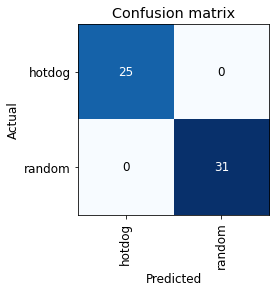

In [14]:
# Confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

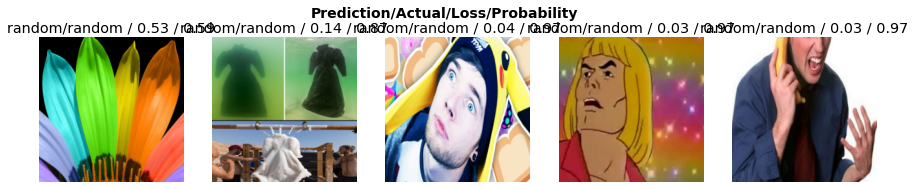

In [15]:
interp.plot_top_losses(5, nrows=1)

In [16]:
# Data cleaning
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [17]:
# Eksportering af model

In [18]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [19]:
learn_inf = load_learner(path/'export.pkl')
learn_inf.dls.vocab

['hotdog', 'random']

Upload af vilkårligt billede


In [22]:
# Indlæsning af modellen
learn_inf = load_learner('export.pkl')
img = PILImage.create(path/'hotdog.jpg')

FileNotFoundError: ignored

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

In [ ]:
pred,pred_idx,probs = learn_inf.predict(img)

In [ ]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

In [ ]:
btn_run = widgets.Button(description='Classify')
btn_run

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [ ]:
VBox([widgets.Label('Select your hotdog!'), 
      btn_upload, btn_run, out_pl, lbl_pred])